In [1]:
import sys
# append the path of the parent directory
sys.path.append("..")

# External library imports
import datetime
import torch
import torch.nn as nn
import numpy as np
import random
from torch.optim import Adam
from torch.utils.data import DataLoader, Subset, random_split
import json
import os
import matplotlib.pyplot as plt

# internal library imports
from dataset import DebrisStatePairsDataset
from model import CNN, UNet
from train import TrainerPairs, CustomDebrisLoss, AdaptiveSparseLoss
from util.setting_utils import set_seed


In [2]:
# Set the random seed for multiple libraries to ensure repeatability

set_seed(42)

In [3]:
# def read_losses(file_path):
#     with open(file_path, 'r') as file:
#         data = json.load(file)
#     # Extract the subfolder name as the series name
#     series_name = os.path.basename(os.path.dirname(file_path))
#     return series_name, data['training_losses'], data['validation_losses']

# def plot_multiple_losses(files, log_y=False):
#     plt.figure(figsize=(12, 6))
    
#     for file_path in files:
#         series_name, training_losses, validation_losses = read_losses(file_path)
#         epochs = range(1, len(training_losses) + 1)
        

#         # plt.plot(epochs, training_losses, 'o-', label=f'{series_name} Training', linewidth=2)
        
#         plt.plot(epochs, validation_losses, 'o--', label=f'{series_name} Validation', linewidth=2)

#     plt.title('Training and Validation Losses for Multiple Models')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.grid(True)
    
#     if log_y:
#         plt.yscale('log')  # Set the y-axis to logarithmic scale
    
#     plt.show()

In [4]:
# files = [
#     '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-26_09-10_FIN_base_model_compar_smoothl1Loss_batch32_timestep1_lr1e-4_l2reg_drop0-2_expdata_prune_CNN/losses_epoch_50.json',
#     '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-26_09-10_FIN_base_model_compar_smoothl1Loss_batch32_timestep1_lr1e-4_l2reg_drop0-2_expdata_prune_SmallUNet/losses_epoch_50.json',
#     '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-26_09-10_FIN_base_model_compar_smoothl1Loss_batch32_timestep1_lr1e-4_l2reg_drop0-2_expdata_prune_MedUNet/losses_epoch_50.json',
#     '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-26_09-10_FIN_base_model_compar_smoothl1Loss_batch32_timestep1_lr1e-4_l2reg_drop0-2_expdata_prune_LargeUNet/losses_epoch_50.json'
# ]

# plot_multiple_losses(files, log_y=True)

In [5]:
# files = [
#     '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-21_base_model_comparison_l1Loss_batch32_lr1e-4_CNN/losses_epoch_30.json',
#     '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-21_base_model_comparison_l1Loss_batch32_lr1e-4_SmallUNet/losses_epoch_30.json',
#     '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-21_base_model_comparison_l1Loss_batch32_lr1e-4_MedUNet/losses_epoch_30.json',
#     '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-21_base_model_comparison_l1Loss_batch32_lr1e-4_LargeUNet/losses_epoch_30.json'
# ]

# plot_multiple_losses(files)

In [6]:
# Parameters

root_dir = r'/home/tom/repos/dyna-landslide-surrogate/data_experiment_prune'
checkpoint_dir = r'/home/tom/repos/dyna-landslide-surrogate/checkpoints'
batch_size = 32
split_proportions = (0.7, 0.15, 0.15)
epochs = 30

in_channels = 3  # Number of input channels (e.g., terrain, velocity, thickness)
out_channels = 2  # Number of output channels (e.g., next velocity, next thickness)

In [7]:
# Data set up

# Initialize dataset with scaling
dataset = DebrisStatePairsDataset(root_dir, array_size=256, apply_scaling=True, timestep_interval=1)

# Split dataset into train, validation, and test sets and create dataloaders
train_loader, val_loader, test_loader = dataset.create_dataloaders(split_proportions, batch_size, random_state=42)



# Dataset stats
print(f"Total dataset size: {len(dataset)}")
print(f"Train size: {len(train_loader.dataset)}, Validation size: {len(val_loader.dataset)}, Test size: {len(test_loader.dataset)}")

Total dataset size: 3665
Train size: 2647, Validation size: 556, Test size: 462


In [8]:
# # Create an instance of each architecture
# cnn = CNN()
# small_unet = UNet(in_channels=3, out_channels=2, features=[64, 128, 256])
# med_unet = UNet(in_channels=3, out_channels=2, features=[64, 128, 256, 512])
# large_unet = UNet(in_channels=3, out_channels=2, features=[64, 128, 256, 512, 1024])

# # Calculate the number of parameters for each architecture
# cnn_params = sum(p.numel() for p in cnn.parameters())
# small_unet_params = sum(p.numel() for p in small_unet.parameters())
# med_unet_params = sum(p.numel() for p in med_unet.parameters())
# large_unet_params = sum(p.numel() for p in large_unet.parameters())

# # Print the number of parameters for each architecture
# print("ComplexCNN parameters:", cnn_params)
# print("SimpleUNet parameters:", small_unet_params)
# print("LargeUNet parameters:", med_unet_params)
# print("UNet parameters:", large_unet_params)

In [9]:
# # Set up CUDA
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# cnn = CNN().to(device)

# # Check if multiple GPUs are available and wrap the model using nn.DataParallel
# if torch.cuda.device_count() > 1:
#     print(f"Using {torch.cuda.device_count()} GPUs!")
#     # This will wrap the model for use with multiple GPUs
#     cnn = nn.DataParallel(cnn)

# # Define the loss function and optimizer
# # criterion = nn.MSELoss()
# criterion = nn.L1Loss()
# # criterion = CustomDebrisLoss(loss_fn_zero=nn.SmoothL1Loss(), loss_fn_debris=nn.SmoothL1Loss(), debris_weight=0.66)
# optimizer = Adam(cnn.parameters(), lr=1e-3)

# cnn_trainer = TrainerPairs(cnn, optimizer, criterion, device, model_name="cnn", checkpoint_dir=checkpoint_dir)

# cnn_trainer.load_checkpoint("/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-26_09-10_FIN_base_model_compar_smoothl1Loss_batch32_timestep1_lr1e-4_l2reg_drop0-2_expdata_prune_CNN/model_epoch_50.pth", train_loader)

In [10]:
# cnn_trainer.test(test_loader)

In [11]:
# cnn_trainer.plot_predictions(test_loader, num_predictions=5)

In [12]:
# # Set up CUDA
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# small_unet = UNet(in_channels=3, out_channels=2, features=[64, 128, 256]).to(device)

# # Check if multiple GPUs are available and wrap the model using nn.DataParallel
# if torch.cuda.device_count() > 1:
#     print(f"Using {torch.cuda.device_count()} GPUs!")
#     # This will wrap the model for use with multiple GPUs
#     small_unet = nn.DataParallel(small_unet)

# # Define the loss function and optimizer
# # criterion = nn.MSELoss()
# criterion = nn.L1Loss()
# # criterion = CustomDebrisLoss(loss_fn_zero=nn.SmoothL1Loss(), loss_fn_debris=nn.SmoothL1Loss(), debris_weight=0.66)
# optimizer = Adam(cnn.parameters(), lr=1e-3)

# small_unet_trainer = TrainerPairs(small_unet, optimizer, criterion, device, model_name="small_unet", checkpoint_dir=checkpoint_dir)

# small_unet_trainer.load_checkpoint("/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-26_09-10_FIN_base_model_compar_smoothl1Loss_batch32_timestep1_lr1e-4_l2reg_drop0-2_expdata_prune_SmallUNet/model_epoch_50.pth", train_loader)

In [13]:
# small_unet_trainer.test(test_loader)

In [14]:
# small_unet_trainer.plot_predictions(test_loader, num_predictions=10)

In [15]:
# Set up CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

med_unet = UNet(in_channels=3, out_channels=2, features=[64, 128, 256, 512]).to(device)

# Check if multiple GPUs are available and wrap the model using nn.DataParallel
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    # This will wrap the model for use with multiple GPUs
    med_unet = nn.DataParallel(med_unet)

# Define the loss function and optimizer
# criterion = nn.MSELoss()
criterion = AdaptiveSparseLoss()
# criterion = nn.L1Loss()
# criterion = CustomDebrisLoss(loss_fn_zero=nn.SmoothL1Loss(), loss_fn_debris=nn.SmoothL1Loss(), debris_weight=0.66)
optimizer = Adam(med_unet.parameters(), lr=1e-3)

med_unet_trainer = TrainerPairs(med_unet, optimizer, criterion, device, model_name="med_unet", checkpoint_dir=checkpoint_dir)

med_unet_trainer.load_checkpoint("/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-26_18-10_base_model_compar_adaploss_batch32_timestep5_lr1e-4_l2reg_drop0-2_expdata_prune_MedUNet_MedUNet/model_epoch_20.pth", train_loader)

Using 2 GPUs!
Model loaded from /home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-26_18-10_base_model_compar_adaploss_batch32_timestep5_lr1e-4_l2reg_drop0-2_expdata_prune_MedUNet_MedUNet/model_epoch_20.pth


In [16]:
med_unet_trainer.test(test_loader)

Test Custom Loss: 0.0391
Test L1 Loss: 0.0271
Test MSE: 0.0012
Test RMSE: 0.0349
Test PSNR: 59.1611


In [17]:
preds = med_unet_trainer.get_predictions(test_loader)

In [18]:
# Dictionary to hold the min and max values for the specific 'predictions' key
min_max_values = {}

# Check and extract min and max only for entries where the key is 'predictions'
for key, value in preds.items():
    if 'predictions' in key:
        min_value = value.min()
        max_value = value.max()
        min_max_values[key] = {'min': min_value, 'max': max_value}

# Printing or returning min and max values for 'predictions'
print(min_max_values)

{'predictions': {'min': 0.0, 'max': 0.86832124}}


In [19]:
print(preds)

{'current': array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

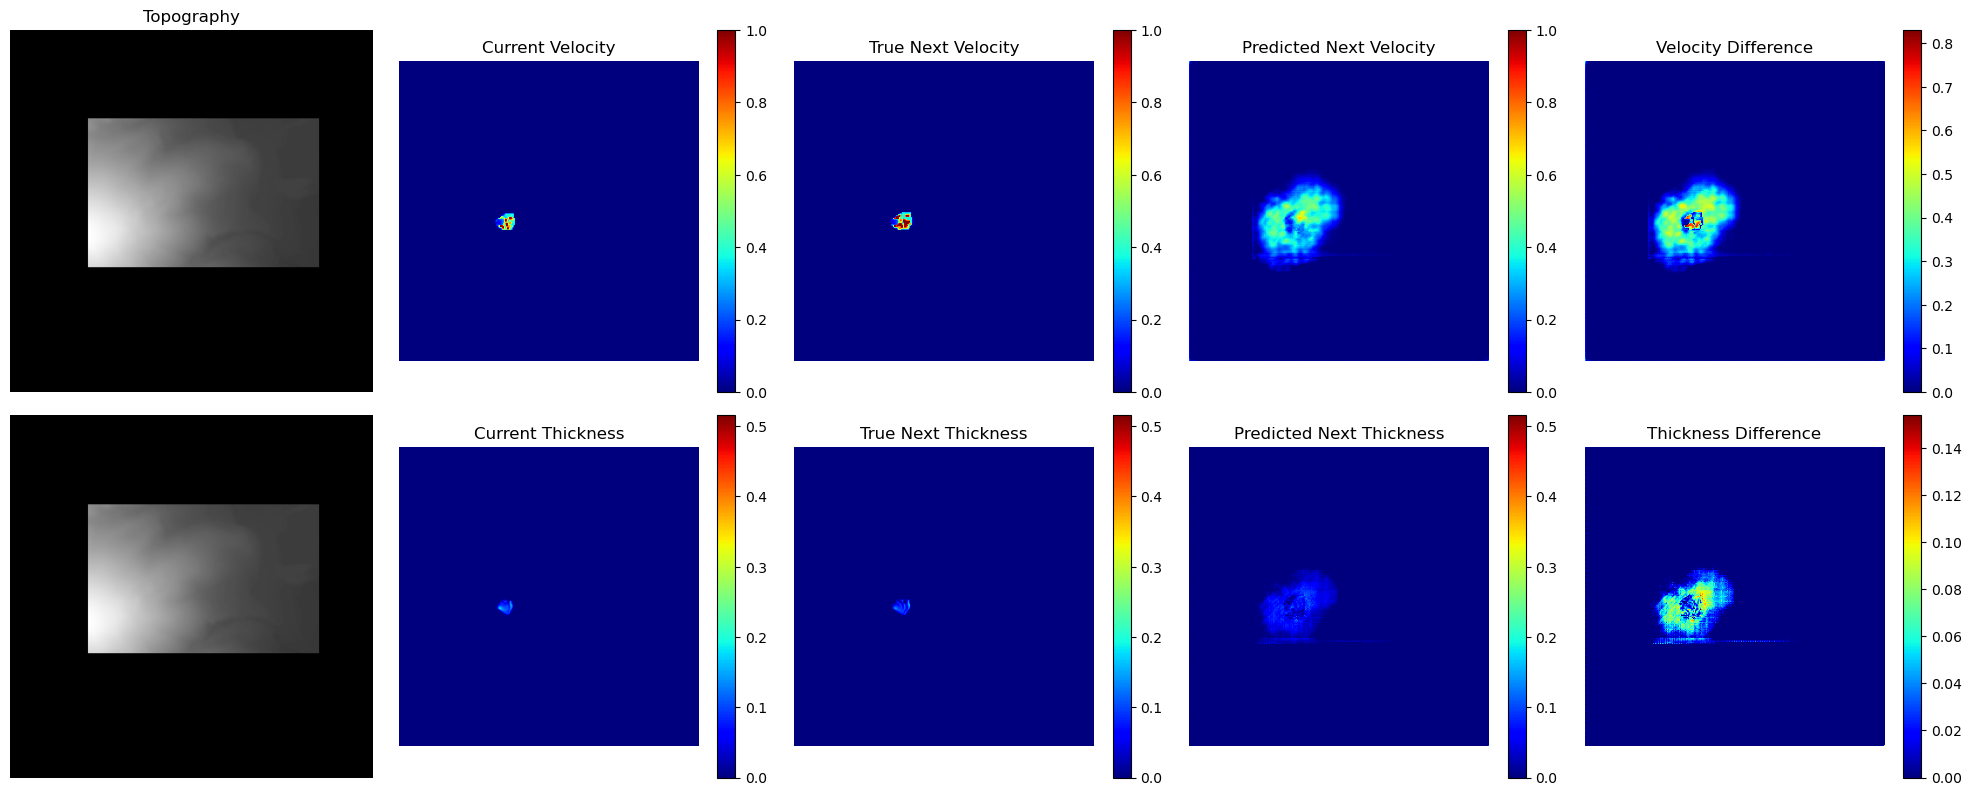

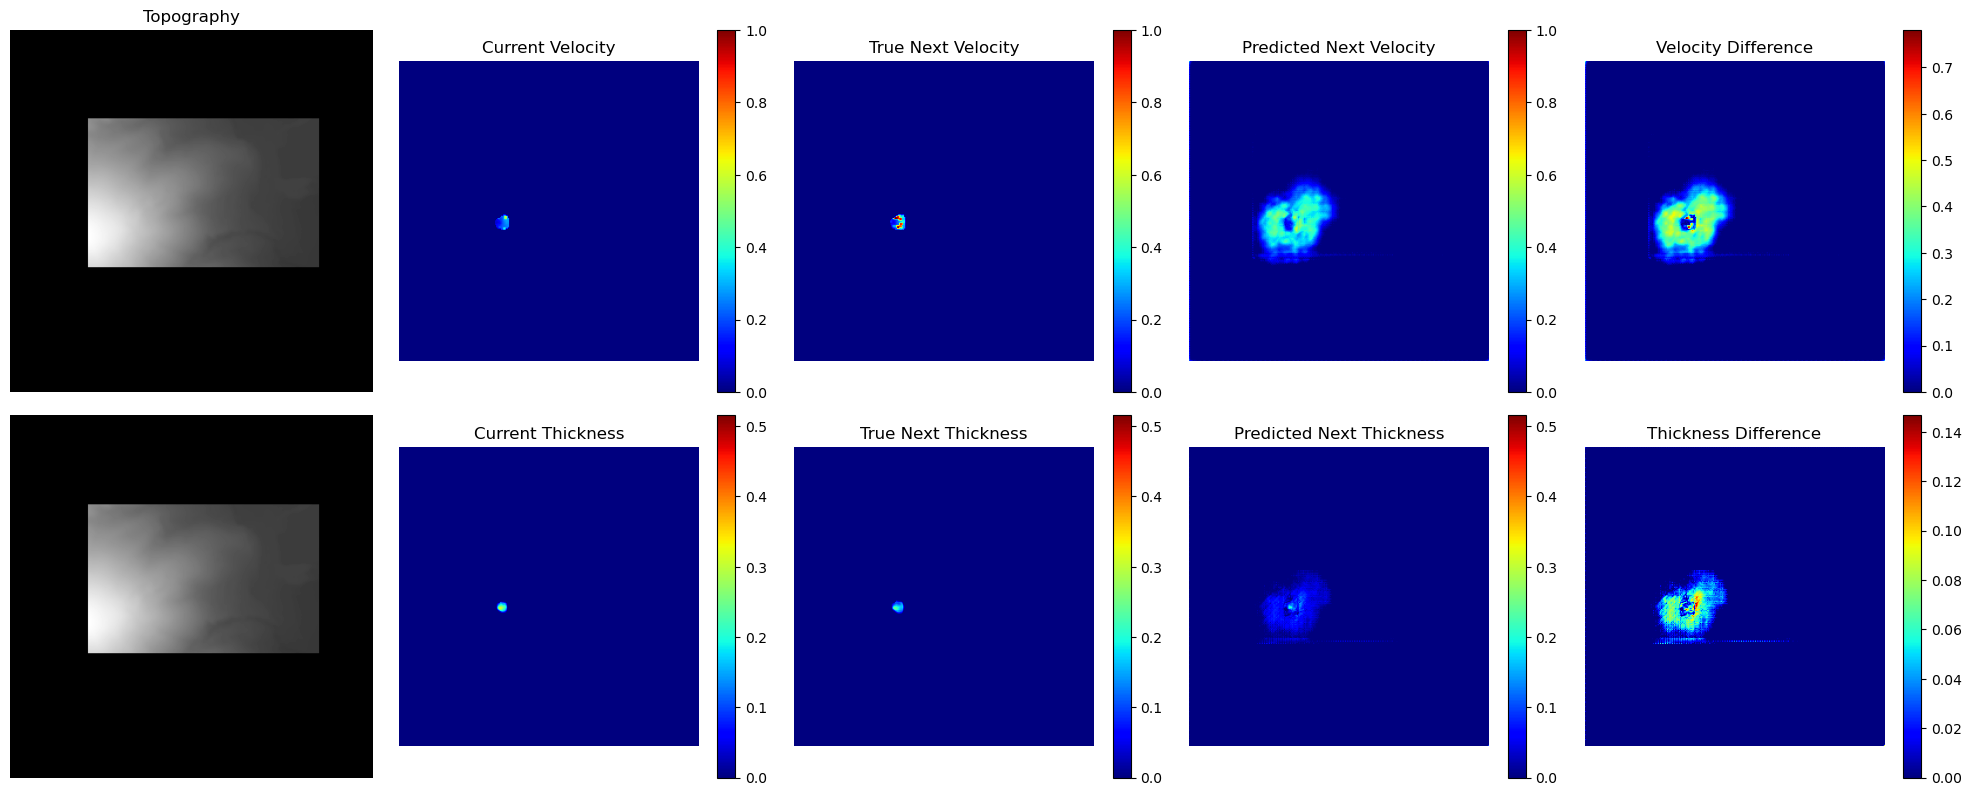

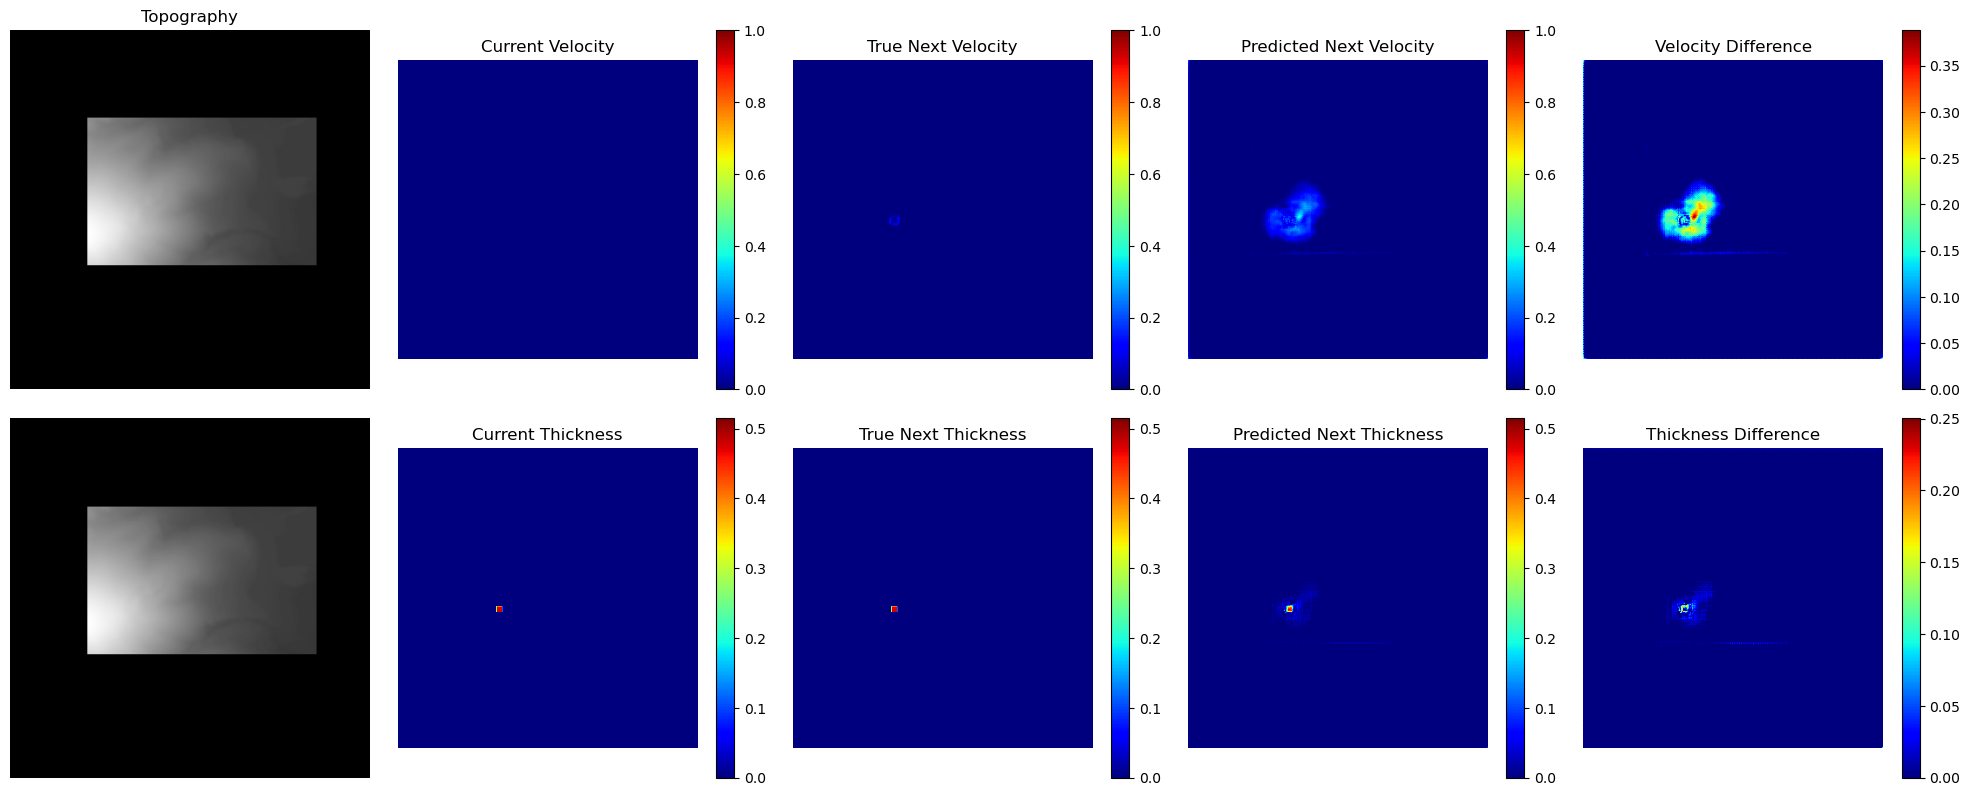

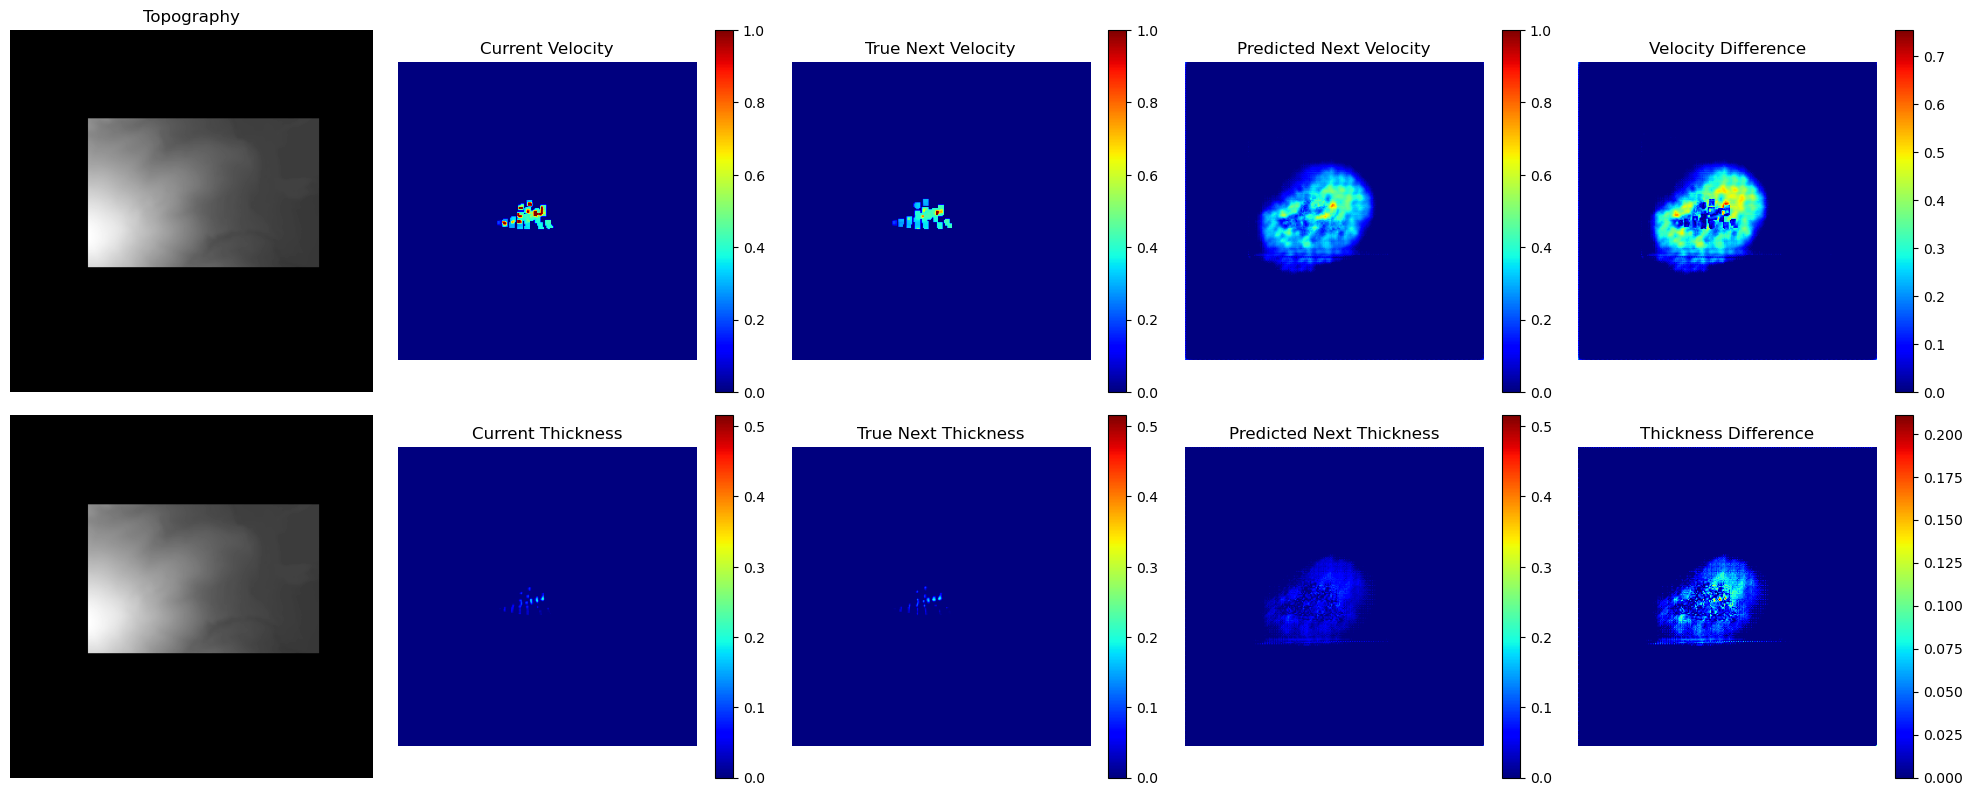

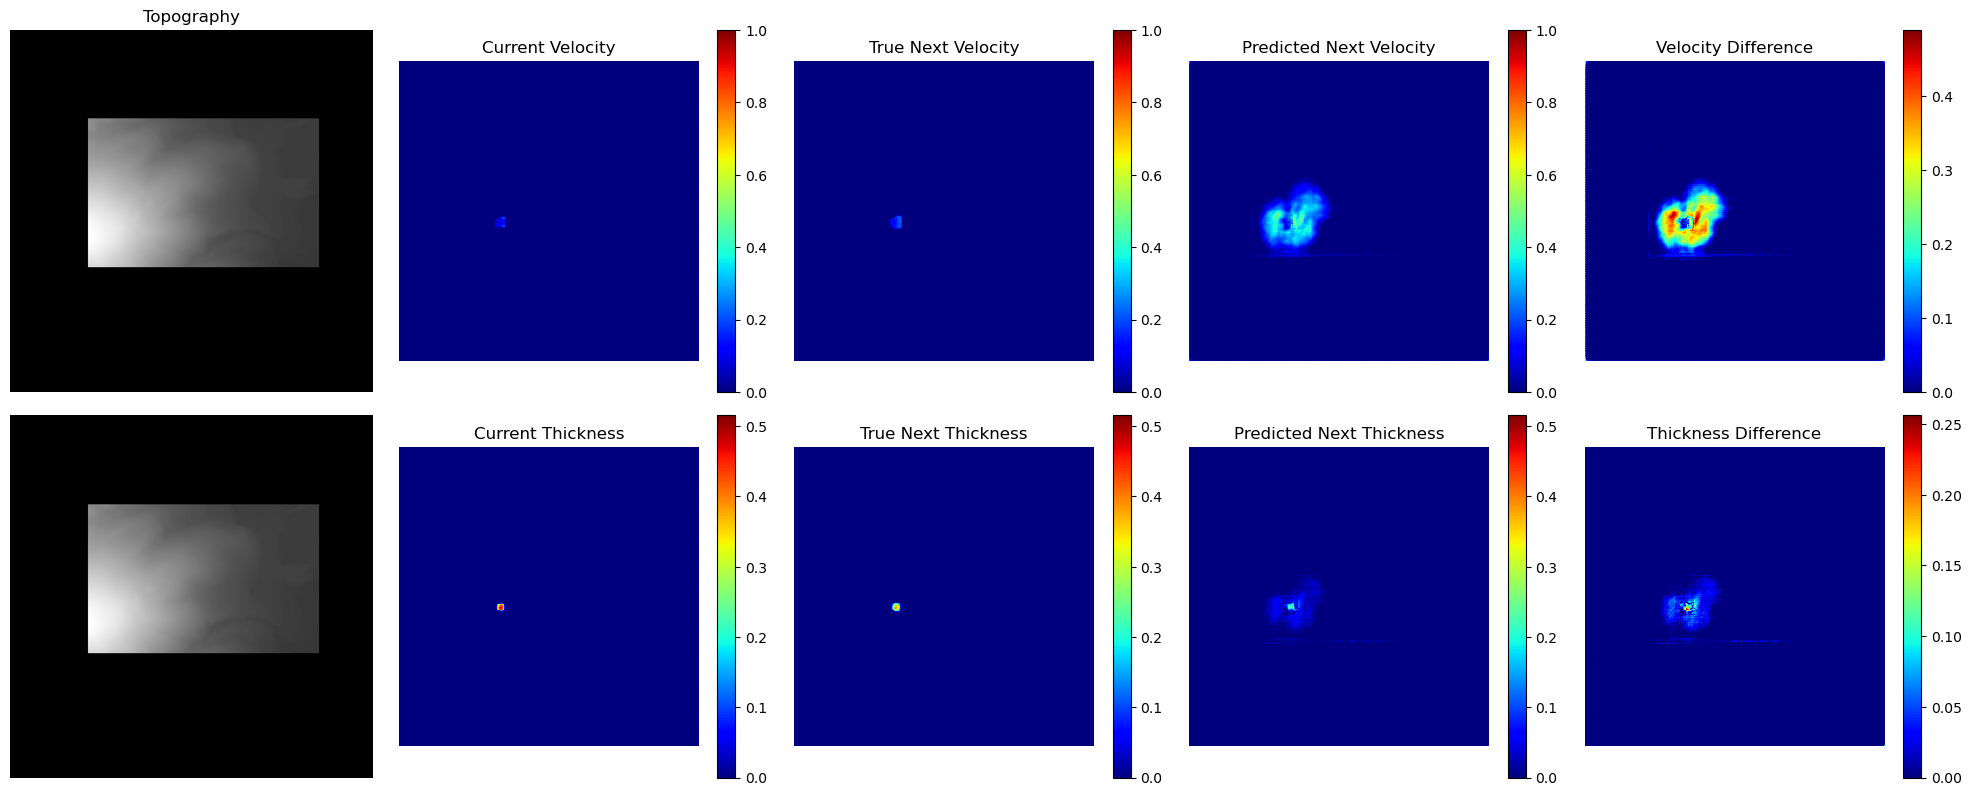

In [21]:
med_unet_trainer.plot_predictions(test_loader, num_predictions=5, batch_index=25)